In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as ssp
import scipy.linalg as salg
from scipy.sparse.linalg import spsolve, splu, inv
from scipy.sparse.csgraph import reverse_cuthill_mckee
from collections.abc import Callable
from sksparse.cholmod import cholesky

In [82]:
#Defining the constants
P = 2		#Power of two
N = 2**P	#Number of subdivisions
U0 = 0.01 	#The border constant we might need to use?
h = 1/N		#Discretisation step

DEBUG = True

In [83]:

def get_elem_mat(N: int, dimension: str) -> ssp.csr_matrix:
	"""Creates the element matrix 'Ah' for the 2D or 3D discrete laplaciaan

	Parameters
	----------
	N : int
	    Number of points in a direction of the grid
	dimension : str
	    2D/3D for two/three-dimensional discrete laplacian

	Returns
	-------
	ssp.csc_matrix
	    The element matrix Ah
	"""	
	one_dim_diff = 2*np.eye((N))-np.eye((N), k=-1)-np.eye((N), k=1)


	ONE_DIM_DIFF	= ssp.csr_matrix(one_dim_diff.astype(int))
	ID 		= ssp.csr_matrix(np.eye(N).astype(int))

	x_dim_diff = (1/(h**2) * ssp.kron(ONE_DIM_DIFF,ID))
	y_dim_diff = (1/(h**2) * ssp.kron(ID, ONE_DIM_DIFF))

	X_DIM_DIFF 	= ssp.csr_matrix(x_dim_diff.astype(int))
	Y_DIM_DIFF 	= ssp.csr_matrix(y_dim_diff.astype(int))
	TWO_LAPLACE 	= ssp.csr_matrix(x_dim_diff + y_dim_diff)

	one_dim_diff = None
	x_dim_diff = None
	y_dim_diff = None

	if dimension == "2D":
		return TWO_LAPLACE

	elif dimension == "3D":	
		z_dim_diff = (1/(h**2)*(
			ssp.kron(ID,
				ssp.kron(ID, ONE_DIM_DIFF)
				)
			)
		)

		Z_DIM_DIFF 	= ssp.csr_matrix(z_dim_diff.astype(int))
		z_dim_diff = None

		THREE_LAPLACE = (ssp.kron(X_DIM_DIFF, ID) 
				+ssp.kron(Y_DIM_DIFF, ID)
				+Z_DIM_DIFF)
		
		return THREE_LAPLACE

	else:
		raise ValueError('string: Dimension, either "2D" or "3D"')


In [84]:
def build_forcing_vector(lin_spaces: list,
			 internal_fun,
			 boundary_fun  = None
			 ) -> np.ndarray:
	"""Builds the RHS of the linear system for a arbitray-dimensional laplacian

	Parameters
	----------
	lin_spaces : list
	    List of arrays of points that will be used to build the meshgrid
	internal_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that coordinate
	boundary_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that boundary coordinate

	Returns
	-------
	np.ndarray
	    The forcing vector
	"""	
	grids = np.meshgrid(*lin_spaces)
	internal_forcing_array = internal_fun(*grids)
	if boundary_fun == None:
		def boundary_fun(*grids):
			return 0*grids[0]
			
	boundary_forcing_array = boundary_fun(*grids)

	dims = len(lin_spaces)
	mask = tuple([slice(1,-1)]*dims)
	forcing, forcing[mask] = boundary_forcing_array, internal_forcing_array[mask]
	print(mask)

	forcing_vector = forcing.flatten()
	return forcing_vector


In [85]:
%%time

def int_forc_fun(x,y):
	return (x**2 + y**2)*np.sin(x*y)

def bound_forc_fun(x,y):
	return np.sin(x*y)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)
z = np.linspace(0,1,N+1)

X, Y = np.meshgrid(x,y)


CPU times: user 1.12 ms, sys: 0 ns, total: 1.12 ms
Wall time: 574 µs


In [86]:
vecF = build_forcing_vector([x,y], int_forc_fun, bound_forc_fun)

(slice(1, -1, None), slice(1, -1, None))


In [87]:
%%time
TWO_LAPLACE = get_elem_mat(N+1, "2D")

CPU times: user 6.39 ms, sys: 0 ns, total: 6.39 ms
Wall time: 3.97 ms


In [88]:
%%time
#Manipulating the 2D-laplacian and the forcing vector to obey boundary elements
#By selecting the boundary points
Xval, Yval = X.ravel(), Y.ravel()

boundary_list = np.squeeze(
	np.where(
		(Xval==x[0]) | (Xval==x[-1]) | (Yval==y[0]) | (Yval==y[-1])
	)
);

SPARSE_ID = ssp.eye((N+1)**2).tocsr()
for row in boundary_list:
	TWO_LAPLACE[row,:] = SPARSE_ID[row,:]



CPU times: user 9.84 ms, sys: 0 ns, total: 9.84 ms
Wall time: 7.13 ms


In [89]:
size = (N+1)**2

TWO_LAPLACE = TWO_LAPLACE.tocsc()
P_MATRIX = ssp.csc_matrix((size,size))


TWO_LAPLACE.shape


(25, 25)

In [90]:
ONES = ssp.csr_matrix((size,size))
ONES[boundary_list,boundary_list] = 1

print(ONES.shape)


(25, 25)


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [91]:
ONES
print(ONES)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0


In [92]:
print(SPARSE_ID)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0


In [93]:
print(boundary_list)

[ 0  1  2  3  4  5  9 10 14 15 19 20 21 22 23 24]


In [94]:
%%time

ZEROES = ssp.csc_matrix((size,size))

for column in boundary_list:
	P_MATRIX[:, column] = TWO_LAPLACE[:, column]
	TWO_LAPLACE[:,column] = ZEROES[:,column]

print(type(TWO_LAPLACE))

TWO_LAPLACE = (TWO_LAPLACE + ONES)
P_MATRIX = (P_MATRIX - ONES)

print(type(TWO_LAPLACE))

<class 'scipy.sparse.csc.csc_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>
CPU times: user 16.4 ms, sys: 1.82 ms, total: 18.2 ms
Wall time: 14 ms


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [123]:
print(P_MATRIX)

  (6, 1)	-16.0
  (7, 2)	-16.0
  (8, 3)	-16.0
  (6, 5)	-16.0
  (8, 9)	-16.0
  (11, 10)	-16.0
  (13, 14)	-16.0
  (16, 15)	-16.0
  (18, 19)	-16.0
  (16, 21)	-16.0
  (17, 22)	-16.0
  (18, 23)	-16.0


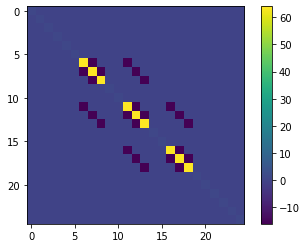

In [95]:
plt.imshow(TWO_LAPLACE.toarray())
plt.colorbar()

In [96]:
TWO_LAPLACE.shape

(25, 25)

In [97]:
pm = P_MATRIX

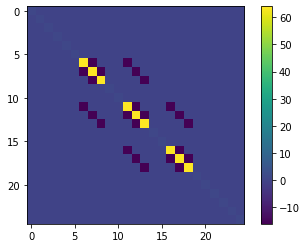

In [98]:
P_MATRIX.shape
plt.imshow(TWO_LAPLACE.toarray())
plt.colorbar()

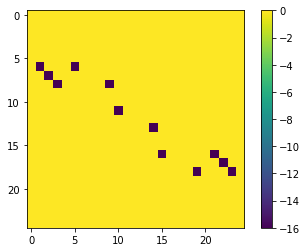

In [99]:
plt.imshow(P_MATRIX.toarray())
plt.colorbar()

In [100]:
#Building u0
U0 = np.sin(X*Y)
u0 = U0.flatten()
to_subtract = P_MATRIX.dot(u0)


In [101]:
vecF = np.subtract(vecF, to_subtract)

In [102]:
TWO_LAPLACE.shape

(25, 25)

In [103]:
print(vecF)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.80741473e-03 3.89608542e-02
 4.07496541e+00 2.47403959e-01 0.00000000e+00 3.89608542e-02
 1.23701980e-01 7.96840505e+00 4.79425539e-01 0.00000000e+00
 4.07496541e+00 7.96840505e+00 2.24124058e+01 6.81638760e-01
 0.00000000e+00 2.47403959e-01 4.79425539e-01 6.81638760e-01
 8.41470985e-01]


In [104]:
%%time
u = spsolve(TWO_LAPLACE, vecF.T)

CPU times: user 2.27 ms, sys: 673 µs, total: 2.94 ms
Wall time: 1.42 ms


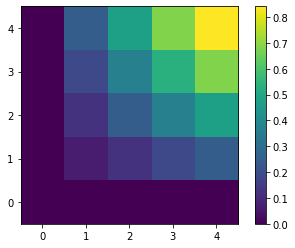

In [105]:
array_u = u.reshape((N+1,N+1))
plt.imshow(array_u, origin='lower');
plt.colorbar()

In [106]:
u_ex = np.sin(X*Y)
vec_u_ex = u_ex.flatten()

In [124]:
error = np.sqrt(h**2 *np.sum((vec_u_ex-u)**2))
print("h**2: {:.5f}\t error: {:.5f}".format(h**2, error))
print('relative error: {:.4f}\t [h**2]'.format(error/(h**2)))

h**2: 0.06250	 error: 0.00002
relative error: 0.0003	 [h**2]


In [108]:
def decomp_lu(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower matrix of the LU decomposition of M

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix to LU decompose such that L@U = M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower matrix L
	"""
	#In this code block all fully uppercase variables are sparse matrices
	shape_m = M.shape
	ID = ssp.eye(shape_m[0])
	ZEROES = ssp.csc_matrix(shape_m)

	SUM = ID.copy()
	for k in range(0, shape_m[1]):
		Akk = M[k,k]
		VEC = M[:,k] / Akk
		VEC[0: k+1] = ZEROES[0:k+1, 0]

		EK = ZEROES[:,0].copy()
		EK[k] = 1

		ADD = VEC * EK.T
		SUM += ADD
	
	L = SUM
	U = spsolve(SUM, M)

	return L, U

In [109]:
from tqdm import tqdm

In [110]:
##Mocht je hier een error krijgen dan moet je waarschijnlijk even het volgende veranderen
## tqdm(range(...)) -> range(...)


def decomp_cholesky(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower triangular matrix C that results from cholesky
	decomposition.

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix M such that cholesky decomposition yields C, scuh that 
	    C@C.T == M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower triangular matrix C
	"""	
	shape_m = M.shape
	ZEROES = ssp.lil_matrix(shape_m)
	C = ssp.lil_matrix(shape_m)
	TMP = M.copy().tolil()

	for col in tqdm(range(0, shape_m[1])): #Hierzo
		C[col,col] = np.sqrt((TMP[col,col] - ( C[col,0:col].power(2) ).sum()))
		TMP[col,col] = C[col,col]

		PROD = TMP[col+1:,0:col]*TMP[col,0:col].T

		SUM = PROD.sum(axis=1)

		pref = 1/(C[col,col])

		C[col+1:,col] = pref*(TMP[col+1:,col] - SUM)
		TMP[col+1:,col] = C[col+1:, col]

		C[col,col+1:] = ZEROES[col,col+1:]

	return C


In [111]:
TWO_LAPLACE.tocsc()

<25x25 sparse matrix of type '<class 'numpy.float64'>'
	with 49 stored elements in Compressed Sparse Column format>

In [112]:
"""
L, U = decomp_lu(TWO_LAPLACE)
D = ssp.diags(U.diagonal(k=0))

plt.imshow(D.toarray())
plt.colorbar()

sqrtD = D.sqrt()

C = L@sqrtD
"""

'\nL, U = decomp_lu(TWO_LAPLACE)\nD = ssp.diags(U.diagonal(k=0))\n\nplt.imshow(D.toarray())\nplt.colorbar()\n\nsqrtD = D.sqrt()\n\nC = L@sqrtD\n'

In [113]:
#Utest = D@L.T

In [114]:
#np.alltrue(Utest.toarray() == U.toarray())

In [115]:
#LU = L@U

#np.alltrue(TWO_LAPLACE.toarray() == LU.toarray())

In [116]:
#np.all(np.linalg.eigvals(TWO_LAPLACE.toarray())>0)

In [117]:
%%time
##Mocht je een error krijgen, lees dan de comment in de cell hierboven
#C = decomp_cholesky(TWO_LAPLACE)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs


In [118]:
%%time

C_factor = cholesky(TWO_LAPLACE, beta=0, ordering_method='natural')


CPU times: user 62 µs, sys: 18 µs, total: 80 µs
Wall time: 82.5 µs


In [119]:
C2 = C_factor.L()
P = C_factor.P()

In [120]:
print(P)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


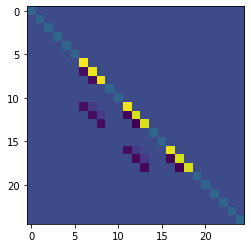

In [121]:
plt.imshow(C2.toarray())

In [122]:
startt = time_ns()
b = spsolve(C2, vecF)
forwt = time_ns() - startt
sol = spsolve(C2.T, b)
backt = time_ns() - startt - forwt
statement = "Forward step took: {:.2f} ms, Backward step took: {:.2f} ms".format(forwt/1e6, backt/1e6)

print(statement)

NameError: name 'time_ns' is not defined

In [ ]:
permut = reverse_cuthill_mckee(TWO_LAPLACE, symmetric_mode=True)
print(permut)

[ 32  49  31  66  48  30  83  65  47  29 100  82  64  46  28 117  99  81
  63  45  27 134 116  98  80  62  44  26 151 133 115  97  79  61  43  25
 168 150 132 114  96  78  60  42  24 185 167 149 131 113  95  77  59  41
  23 202 184 166 148 130 112  94  76  58  40  22 219 201 183 165 147 129
 111  93  75  57  39  21 236 218 200 182 164 146 128 110  92  74  56  38
  20 253 235 217 199 181 163 145 127 109  91  73  55  37  19 270 252 234
 216 198 180 162 144 126 108  90  72  54  36  18 269 251 233 215 197 179
 161 143 125 107  89  71  53  35 268 250 232 214 196 178 160 142 124 106
  88  70  52 267 249 231 213 195 177 159 141 123 105  87  69 266 248 230
 212 194 176 158 140 122 104  86 265 247 229 211 193 175 157 139 121 103
 264 246 228 210 192 174 156 138 120 263 245 227 209 191 173 155 137 262
 244 226 208 190 172 154 261 243 225 207 189 171 260 242 224 206 188 259
 241 223 205 258 240 222 257 239 256   7   1   2   3   4   5  34   6  10
   8   9  11  12  17  14  15  16  33  13 288  50  5

In [ ]:
REDUCED_BAND = TWO_LAPLACE[permut[:,np.newaxis], permut[np.newaxis,:]]

In [ ]:
RED_BAND_FACT = cholesky(TWO_LAPLACE, beta=0, ordering_method='natural')
C = RED_BAND_FACT.L()

In [ ]:
startt = time_ns()
b = spsolve(C, vecF)
forwt = time_ns() - startt
sol = spsolve(C.T, b)
backt = time_ns() - startt - forwt
statement = "Forward step took: {:.2f} ms, Backward step took: {:.2f} ms".format(forwt/1e6, backt/1e6)

print(statement)

Forward step took: 1.25 ms, Backward step took: 0.52 ms


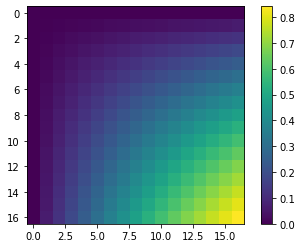

In [ ]:
toplot = sol.reshape((N+1,N+1))
plt.imshow(toplot)
plt.colorbar()

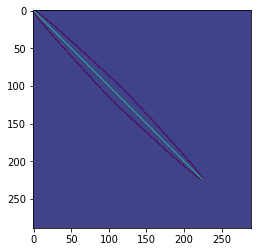

In [ ]:
plt.imshow(REDUCED_BAND.toarray())

In [ ]:
#np.alltrue(C.toarray() == C2.toarray())

plt.close()
plt.imshow(C2.toarray())
plt.colorbar()

MAYBE = C2@C2.T
plt.imshow(MAYBE.toarray())
plt.colorbar()

U_MAYBE = spsolve(MAYBE, vecF)

u_maybe = (U_MAYBE).reshape((N+1,N+1))
plt.imshow(u_maybe, origin='lower')
plt.colorbar()

In [ ]:
from time import time_ns

In [ ]:
def sys_solve_chol(f: ssp.csc_matrix, L: ssp.csc_matrix, U: ssp.csc_matrix) -> ssp.csc_matrix:
	LOWER = L #Forward matrix
	UPPER = U #Backward

	startt = time_ns()
	b = spsolve(LOWER, f)
	forwt = time_ns() - startt
	sol = spsolve(UPPER, b)
	backt = time_ns() - startt - forwt

	statement = "Forward step took: {:.2f} ms, Backward step took: {:.2f} ms".format(forwt/1e6, backt/1e6)

	return sol, statement


In [ ]:
%%time

#u, state = sys_solve_chol(vecF, L, U)

#print(state)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [ ]:
#nonzero counting

nnzA = TWO_LAPLACE.count_nonzero()
nnzA2 = REDUCED_BAND.count_nonzero()
nnzC = C.count_nonzero()
nnzC2 = C2.count_nonzero()

fill_ratio = nnzC / nnzA
fillratio2 = nnzC2 / nnzA2

print(fill_ratio, fillratio2)


3.058458813108946 3.058458813108946


In [ ]:
E = -1*ssp.tril(TWO_LAPLACE, k=-1)
F = -1*ssp.triu(TWO_LAPLACE, k=1)
D = ssp.diags(TWO_LAPLACE.diagonal())

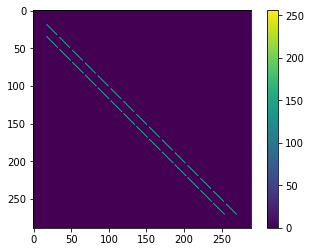

In [ ]:
plt.imshow(E.toarray())
plt.colorbar()

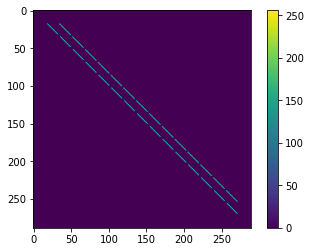

In [ ]:
plt.imshow(F.toarray())
plt.colorbar()

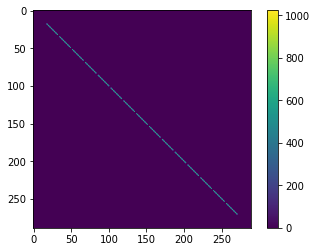

In [ ]:
plt.imshow(D.toarray())
plt.colorbar()

In [ ]:
omega = 1.5

MINV = omega*(2-omega) * inv(D - omega* E) @ D @ inv(D - omega*F)

shape = MINV.shape
ID = ssp.csc_matrix(shape)

/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [ ]:
u0 = ssp.csr_matrix(np.zeros(shape[0]))
r0 = ssp.csr_matrix(np.ones(shape[0]))
f = ssp.csr_matrix(vecF)

print(vec_u_ex.shape)
print(u0.shape)

epsilon = 1e-3


(289,)
(1, 289)


In [ ]:
def get_norm(vector: ssp.csc_matrix) -> float:
	norm = np.sqrt((vector.power(2)).sum())
	return norm

In [ ]:
"""norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T


i = 0
for i in range(40000):
	u = u + MINV@r
	r = COMP@r

	norm_r = get_norm(r)

	if norm_r / norm_f < epsilon:
		break

print(norm_r/norm_f)
print(i)
"""

COMP = (ID - TWO_LAPLACE@MINV)

norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T

print(type(MINV))
print(type(r))
print(type(u))

r_norms = np.asarray([norm_r])

i = 0
while not norm_r/norm_f < epsilon:
	u = (1-omega)*u + omega*MINV@r
	r = COMP@r

	norm_r = get_norm(r)
	r_norms = np.append(r_norms, norm_r)
	if i % 1000 == 0:
		print(i, norm_r/norm_f)
	i += 1



u_ssor = u

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>
0 1.0631118184327988
1000 1.1254400314597945
2000 1.1161659067054757
3000 1.1118057144373927
4000 1.1094229770331414
5000 1.1078668756849746
6000 1.1066753475384823
7000 1.1056555017538903
8000 1.104722562711575
9000 1.1038369803095642
10000 1.1029791399756885
11000 1.1021387580412387
12000 1.1013101921555624
13000 1.1004902384989457
14000 1.0996770323469176
15000 1.0988694687593143
16000 1.098066883753771
17000 1.0972688731269518
18000 1.0964751871969027
19000 1.0956856687558894
20000 1.0949002161529304
21000 1.0941187611997547
22000 1.0933412559002924
23000 1.0925676644622007
24000 1.091797958481496
25000 1.0910321140375225
26000 1.0902701099394587
27000 1.0895119266676199
28000 1.0887575457341105
29000 1.0880069492966629
30000 1.08726011992539
31000 1.0865170404619005
32000 1.0857776939341535
33000 1.0850420635050273
34000 1.084310132441238
35000 1.0835818840945328
36000

KeyboardInterrupt: 

In [ ]:

COMP = (ID - TWO_LAPLACE@MINV)
A = TWO_LAPLACE

norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T
f = f.T

r_norms = np.asarray([norm_r])
n = A.shape[0]

j = 0
while not norm_r/norm_f < epsilon:
	for i in range(n):
		sigma = u[i]
		u[i] = (f[i] - A[i,0:i]@u[0:i] - A[i,i+1:n]@u[i+1:n])/A[i,i]
		u[i] = (1-omega)*sigma + omega*u[i]
	
	for i in range(n-1,0,-1):
		sigma = u[i]
		u[i] = (f[i] - A[i,0:i]@u[0:i] - A[i,i+1:n]@u[i+1:n])/A[i,i]
		u[i] = (1-omega)*sigma + omega*u[i]
	

	r = f - A@u

	norm_r = get_norm(r)
	if j % 1000 == 0:
		print("iteration {:.2f}, norm {:.2e}".format(j,norm_r))
	j += 1
	
u_ssor2 = u


iteration 0.00, norm 9.60e+00


u = u0.T
f = ssp.csc_matrix(vecF).T
A = TWO_LAPLACE
norm_r = get_norm(r0)
norm_f = get_norm(f)
r = r0.T

E = -1*ssp.tril(TWO_LAPLACE, k=-1)
F = -1*ssp.triu(TWO_LAPLACE, k=1)
D = ssp.diags(TWO_LAPLACE.diagonal())

i = 0
while not norm_r/norm_f < epsilon:
	sigma = u
	u = (f + E@u + F@u)
	diag = ssp.csc_matrix(A.diagonal()).T
	
	for idx in range(u.shape[0]):
		u[idx] = u[idx] / diag[idx]

	u = ssp.csc_matrix(u)
	u = (1-omega)*sigma + omega*u
	r = COMP@r
	norm_r = get_norm(r)
	i += 1
	if i % 100 == 0:
		print(norm_r)
	if i == 1000:
		break

u_ssor3 = u
	

In [ ]:
print(i)

1


In [ ]:

len(r_norms)

1

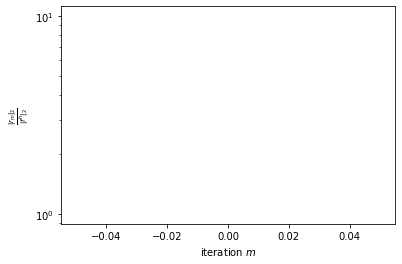

In [ ]:
plt.plot(np.arange(len(r_norms)), r_norms)
plt.semilogy()
plt.ylabel(r"$\frac{|r_m|_2}{|f^h|_2}$")
plt.xlabel(r"iteration $m$")
plt.show()

In [ ]:
"""
norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T

COMP = (ID - TWO_LAPLACE@MINV)

i = 0
A = TWO_LAPLACE
for iter in range(2000):
	uold = u
	for i in range(shape[0]):
		sub1 = A[i,:i]@u[:i]
		print(sub1.shape)
		sub2 = A[i,i+1:]@u[i+1:]/A[i,i]
		print(sub2.shape)
		u[i] = f[i] - sub1[0,0] - sub2[0,0]
	u = (1-omega)*uold + omega*u

	if norm_r / norm_f < epsilon:
		break
"""

'\nnorm_f = get_norm(f)\nnorm_r = get_norm(r0)\n\nu = u0.T\nr = f.T\n\nCOMP = (ID - TWO_LAPLACE@MINV)\n\ni = 0\nA = TWO_LAPLACE\nfor iter in range(2000):\n\tuold = u\n\tfor i in range(shape[0]):\n\t\tsub1 = A[i,:i]@u[:i]\n\t\tprint(sub1.shape)\n\t\tsub2 = A[i,i+1:]@u[i+1:]/A[i,i]\n\t\tprint(sub2.shape)\n\t\tu[i] = f[i] - sub1[0,0] - sub2[0,0]\n\tu = (1-omega)*uold + omega*u\n\n\tif norm_r / norm_f < epsilon:\n\t\tbreak\n'

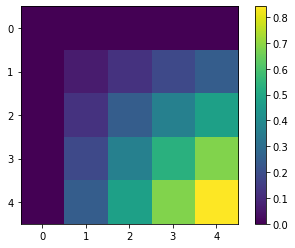

In [ ]:
plt.imshow(vec_u_ex.reshape((N+1,N+1)))
plt.colorbar()

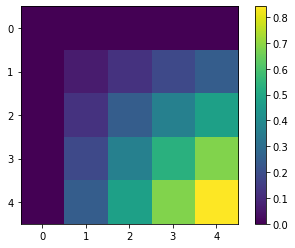

In [ ]:
plt.imshow((u_ssor2.toarray()).reshape((N+1,N+1)))
plt.colorbar()

In [ ]:
#Preconditioned Conjugate-Gradient
u = u0.T
r = f.T

norm_f = get_norm(f)
norm_r = get_norm(r0)

r_prev = 0
z_prev = 0
p = 0

i = 0
while not norm_r/norm_f < epsilon:
	r_pprev = r_prev
	r_prev = r
	z_pprev = z_prev
	p_prev = p
	
	z_prev = MINV@r_prev

	if i == 0:
		p = z_prev
	else:
		beta = (r_prev.T @ z_prev)/(r_pprev.T @ z_pprev)
		p = z_prev + beta[0,0]*p_prev
	
	alpha = (r_prev.T @ z_prev)/(p.T @ TWO_LAPLACE @ p)
	u += alpha[0,0]*p
	r += -alpha[0,0]*(TWO_LAPLACE@p)
	i += 1
	norm_r = get_norm(r)

print(i)
u_preccg = u

ValueError: dimension mismatch

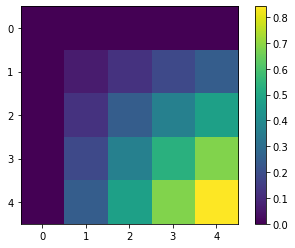

In [ ]:
plt.imshow((u_preccg.toarray()).reshape((N+1,N+1)))
plt.colorbar()

In [ ]:
u_preccg = u_preccg.toarray().reshape((N+1,N+1))
u_ssor = u_ssor.toarray().reshape((N+1,N+1))

/tmp/ipykernel_261/108008612.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(u_ssor/u_preccg)


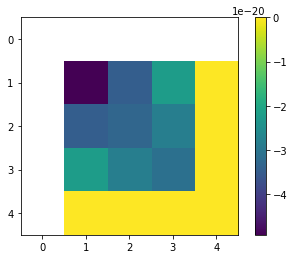

In [ ]:
plt.imshow(u_ssor/u_preccg)
plt.colorbar()